In [9]:
START_LAT = 51.963517
START_LON = 7.615650

# TARGET_LAT = 36.998833
# TARGET_LON = -8.947900

TARGET_LAT = 65.6901330969877
TARGET_LON = -23.274157404633595

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from point_to_point_optimizer import optimize_point_to_point

# Path to precomputed transition indices (adjust if needed)
TRANSITION_FILE = "/home/kbrennan/data/balloon/transition_matrices/transition_indices_20240914_20_20240917_20_dt7200.nc"

ds = xr.open_dataset(TRANSITION_FILE)

# Interpret lat_idx as i (meridional index), lon_idx as j (zonal index)
next_i = ds["lat_idx"].values.astype(int)
next_j = ds["lon_idx"].values.astype(int)

print("Transition field shape (Nt, Nz, Nx, Ny):", next_i.shape)

Transition field shape (Nt, Nz, Nx, Ny): (73, 11, 361, 720)


In [11]:
# Map start/target lat/lon to nearest grid indices
lats = ds["lat"].values
lons = ds["lon"].values

# Note: i index corresponds to latitude, j index to longitude
i0 = int(np.argmin(np.abs(lats - START_LAT)))
j0 = int(np.argmin(np.abs(lons - START_LON)))
it = int(np.argmin(np.abs(lats - TARGET_LAT)))
jt = int(np.argmin(np.abs(lons - TARGET_LON)))

print("Origin (i0, j0):", i0, j0)
print("Target (it, jt):", it, jt)

Origin (i0, j0): 284 375
Target (it, jt): 311 313


In [ ]:
# Run point-to-point optimizer

B = 50.0  # total consumable budget (adjust as needed)

reachable, path, best_value, best_cost = optimize_point_to_point(
    next_i=next_i,
    next_j=next_j,
    origin=(i0, j0),
    target=(it, jt),
    B=B,
)

print("Reachable:", reachable)
if reachable:
    print("Best value:", best_value)
    print("Best cost:", best_cost)
    print("Path length:", len(path))

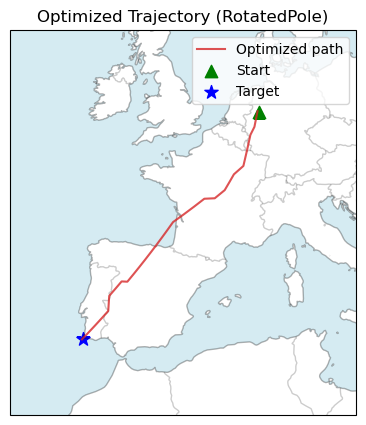

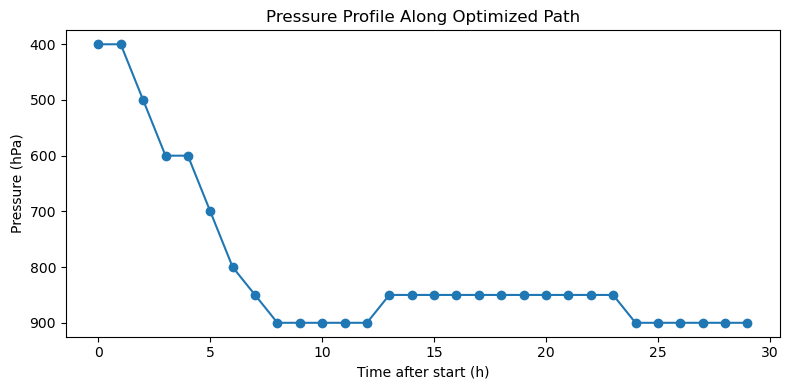

In [ ]:
if not reachable or path is None:
    print("No reachable path to plot.")

else:
    # Extract indices along the path
    k_idx = path[:, 0]
    i_idx = path[:, 1]
    j_idx = path[:, 2]
    l_idx = path[:, 3]

    # Map indices to coordinates
    lats = ds["lat"].values[i_idx]
    lons = ds["lon"].values[j_idx]
    times = ds["time"].values[k_idx]
    plevs = ds["plev"].values[l_idx]  # Pa

    # 1) Map plot of the horizontal path (RotatedPole like in test_lagranto)
    projection_center = (float(lons.mean()), float(lats.mean()))
    padding = 5.0

    projection = ccrs.RotatedPole(
        pole_longitude=projection_center[0] - 180.0,
        pole_latitude=90.0 - projection_center[1],
    )

    fig, ax = plt.subplots(
        1,
        1,
        figsize=(5, 5),
        subplot_kw={"projection": projection},
    )

    ax.coastlines(alpha=0.3)
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.5)
    ax.add_feature(cfeature.BORDERS, alpha=0.2)

    ax.plot(
        lons,
        lats,
        "-",
        color="tab:red",
        transform=ccrs.PlateCarree(),
        label="Optimized path",
        alpha=0.8,
    )

    ax.scatter(
        [START_LON],
        [START_LAT],
        color="green",
        marker="^",
        s=80,
        transform=ccrs.PlateCarree(),
        label="Start",
    )

    ax.scatter(
        [TARGET_LON],
        [TARGET_LAT],
        color="blue",
        marker="*",
        s=100,
        transform=ccrs.PlateCarree(),
        label="Target",
    )

    ax.set_extent(
        [
            float(lons.min()) - padding,
            float(lons.max()) + padding,
            float(lats.min()) - padding,
            float(lats.max()) + padding,
        ],
        crs=ccrs.PlateCarree(),
    )

    ax.legend()
    ax.set_title("Optimized Trajectory (RotatedPole)")

    # 2) Pressure profile along the path, x-axis in hours after start
    fig2, ax2 = plt.subplots(figsize=(8, 4))

    # Convert Pa to hPa for readability
    p_hpa = plevs / 100.0

    # Time since first step in hours
    t0 = times[0]
    time_hours = (times - t0) / np.timedelta64(1, "h")
    ax2.plot(time_hours, p_hpa, "-o")
    ax2.set_xlabel("Time after start (h)")
    ax2.set_ylabel("Pressure (hPa)")
    ax2.invert_yaxis()
    ax2.set_title("Pressure Profile Along Optimized Path")
    fig2.tight_layout()